In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import zipfile

%matplotlib inline
import cv2
from cv2 import resize
import torch
from torch.utils.data import DataLoader,Subset
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import torchvision
from collections import Counter
from PIL import Image
from torchsummary import summary
from sklearn.metrics import classification_report


#from fastapi import FastAPI, File, UploadFile, HTTPException
#from fastapi.responses import JSONResponse

In [ ]:
import os
print(os.listdir('/content/drive/My Drive/'))


['Colab Notebooks', 'Aamal-Maher.pdf', 'IMG-20240912-WA0029.jpg', 'cv (2) (2).pdf', 'cv (2) (1).pdf', 'cv (2).pdf', 'my_port.pdf', 'SAVE_20241102_222924.jpg', 'Photoroom-20241117_223326.png', 'Classroom', 'AI__2', 'Robotic_Task', 'Robotic_Task.py', 'Aamal-Maher .pdf', 'Aamal Maher .pdf', 'Graduation', 'fault_solar_panel', 'main1.py', 'main2.py', 'main3.py', 'main4.py', 'ML_task1.gform']


In [ ]:
#Create Files_Name
image_data='/content/drive/My Drive/fault_solar_panel'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

Files_Name
0  Electrical-damage
1    Physical-Damage
2       Snow-Covered
3              Dusty
4              Clean
5          Bird-drop

In [ ]:
img_height = 244
img_width = 244
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

data_dir = '/content/drive/My Drive/fault_solar_panel'

train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)



In [ ]:
class_names = train_dataset.classes
print(class_names)

['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


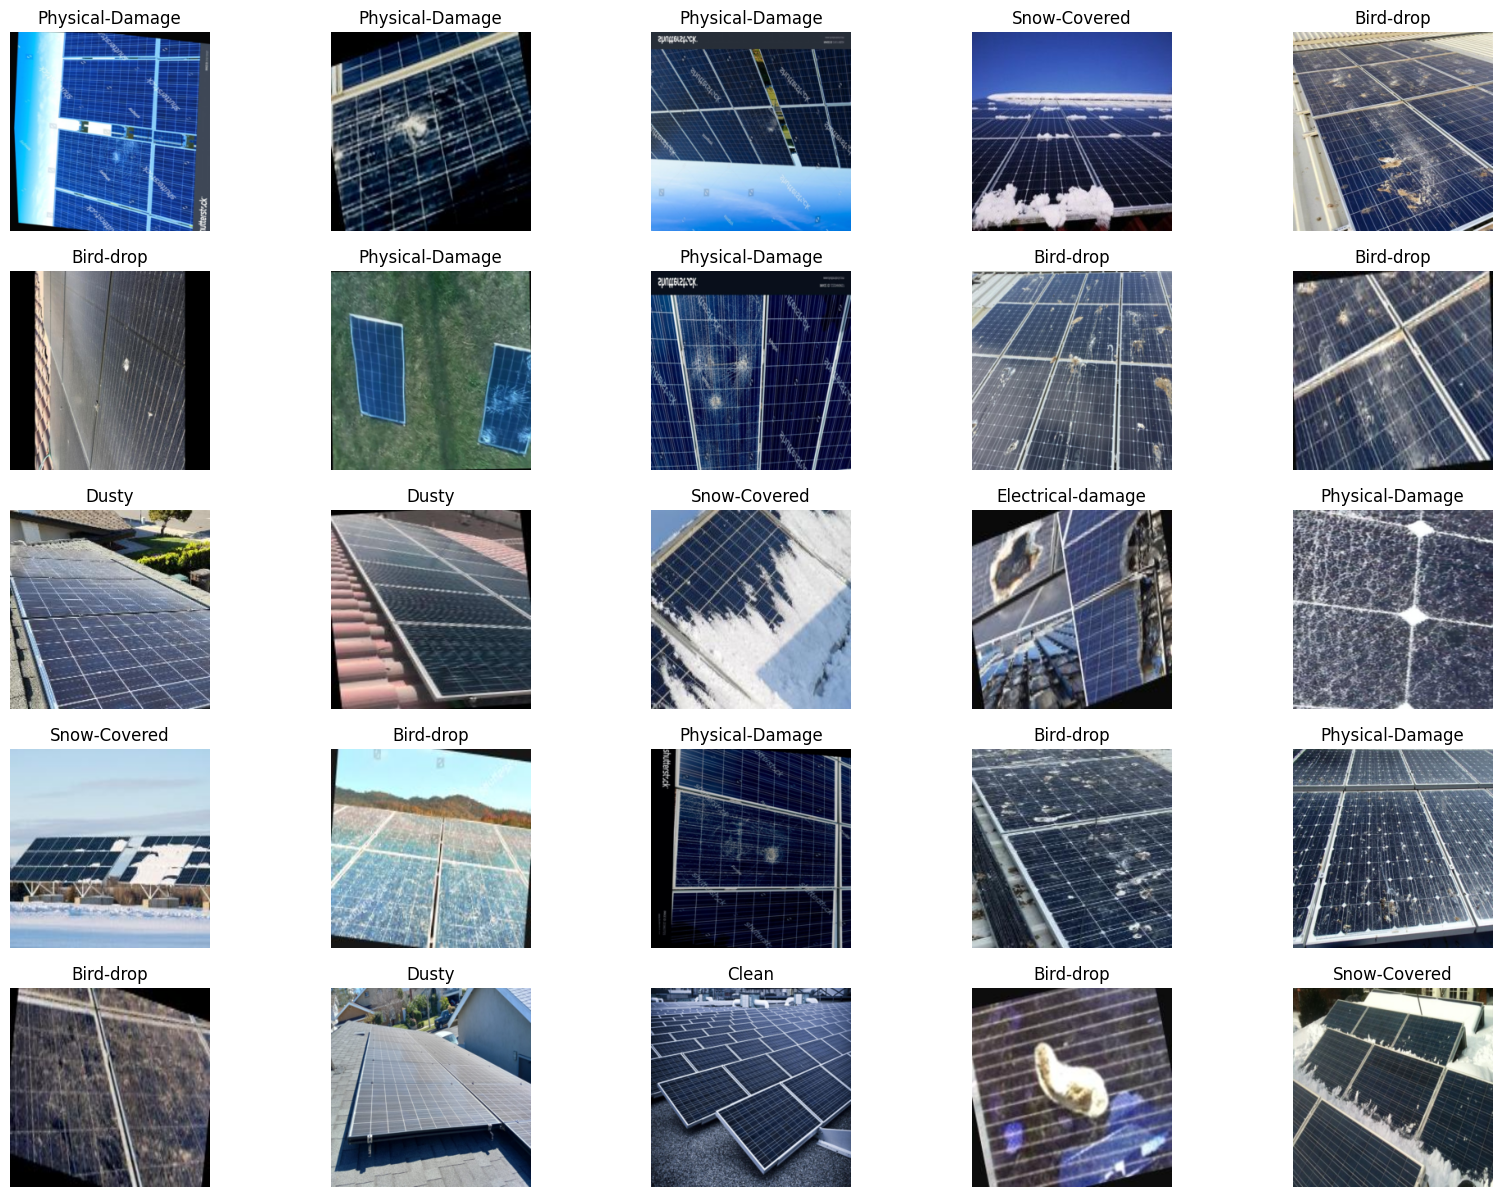

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(20, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.show()


In [ ]:
class_counts = Counter([label for _, label in train_dataset.samples])
for class_idx, count in class_counts.items():
    print(f"{class_names[class_idx]}: {count} images")

Bird-drop: 697 images
Clean: 947 images
Dusty: 654 images
Electrical-damage: 320 images
Physical-Damage: 1341 images
Snow-Covered: 424 images


## First Pretrained Model as Feature Extraction





In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT).to(device)

num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n")

Epoch [1/10]
Train Loss: 0.6219, Train Accuracy: 78.98%
Val Loss: 0.3920, Val Accuracy: 86.89%

Epoch [2/10]
Train Loss: 0.2607, Train Accuracy: 91.67%
Val Loss: 0.2045, Val Accuracy: 92.93%

Epoch [3/10]
Train Loss: 0.1722, Train Accuracy: 94.55%
Val Loss: 0.2681, Val Accuracy: 91.90%

Epoch [4/10]
Train Loss: 0.1822, Train Accuracy: 93.84%
Val Loss: 0.2250, Val Accuracy: 92.82%

Epoch [5/10]
Train Loss: 0.1132, Train Accuracy: 96.29%
Val Loss: 0.2915, Val Accuracy: 91.33%

Epoch [6/10]
Train Loss: 0.1204, Train Accuracy: 96.21%
Val Loss: 0.2636, Val Accuracy: 91.79%

Epoch [7/10]
Train Loss: 0.0790, Train Accuracy: 97.58%
Val Loss: 0.2608, Val Accuracy: 93.50%

Epoch [8/10]
Train Loss: 0.1015, Train Accuracy: 96.61%
Val Loss: 0.2061, Val Accuracy: 93.73%

Epoch [9/10]
Train Loss: 0.0659, Train Accuracy: 97.75%
Val Loss: 0.1623, Val Accuracy: 95.67%

Epoch [10/10]
Train Loss: 0.0937, Train Accuracy: 97.29%
Val Loss: 0.2158, Val Accuracy: 94.41%



In [ ]:
train_losses = [0.6219, 0.2607, 0.1722, 0.1822, 0.1132, 0.1204, 0.0790, 0.1015, 0.0659, 0.0937]
val_losses   = [0.3920, 0.2045, 0.2681, 0.2250, 0.2915, 0.2636, 0.2608, 0.2061, 0.1623, 0.2158]

train_accuracies = [78.98, 91.67, 94.55, 93.84, 96.29, 96.21, 97.58, 96.61, 97.75, 97.29]
val_accuracies   = [86.89, 92.93, 91.98, 92.82, 91.33, 91.79, 93.58, 93.73, 95.67, 94.41]


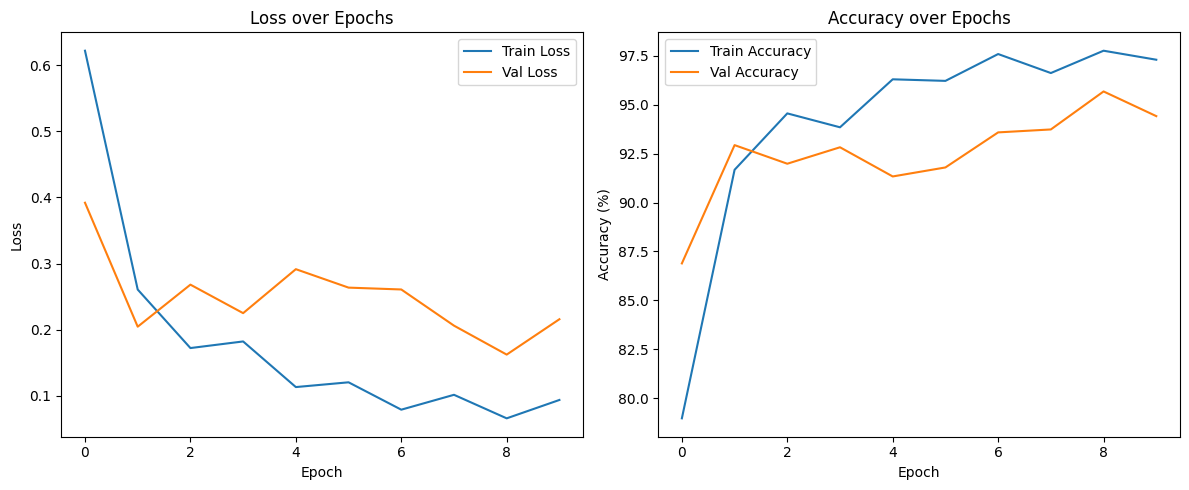

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

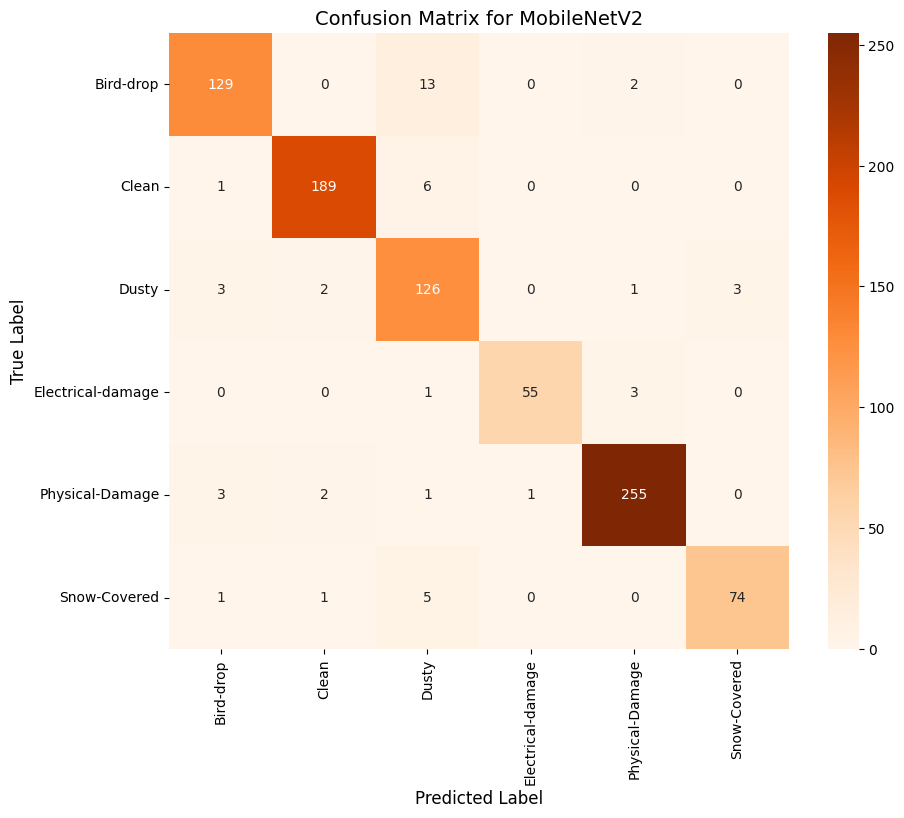

In [ ]:
def compute_confusion_matrix(model, dataloader, device, class_names):
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix for MobileNetV2", fontsize=14)
    plt.show()

compute_confusion_matrix(model, val_loader, device, class_names)


In [ ]:
def compute_classification_report(model, dataloader, device, class_names):
    y_true, y_pred = [], []


    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())


    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(" Classification Report for MobileNetV2:\n")
    print(report)


compute_classification_report(model, val_loader, device, class_names)

 Classification Report for MobileNetV2:

                   precision    recall  f1-score   support

        Bird-drop     0.9416    0.8958    0.9181       144
            Clean     0.9742    0.9643    0.9692       196
            Dusty     0.8289    0.9333    0.8780       135
Electrical-damage     0.9821    0.9322    0.9565        59
  Physical-Damage     0.9770    0.9733    0.9751       262
     Snow-Covered     0.9610    0.9136    0.9367        81

         accuracy                         0.9441       877
        macro avg     0.9442    0.9354    0.9390       877
     weighted avg     0.9467    0.9441    0.9447       877



In [ ]:
torch.save(model.state_dict(), 'model_1.pth')


In [ ]:
from google.colab import files
files.download('model_1.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Transfer Learning Fintuning with Balancing Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and adjust classifier
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_classes = len(train_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)


In [ ]:
# Freeze all layers first
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze last 5 layers
for layer in list(model.features.children())[-5:]:
    for param in layer.parameters():
        param.requires_grad = True



In [ ]:
# Weighted loss
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
counts = torch.tensor([class_counts[i] for i in range(num_classes)], dtype=torch.float)
weights = 1.0 / counts
class_weights = weights / weights.sum()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [ ]:
# Optimizer and scheduler
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params_to_update, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)


In [ ]:
# Training loop setup
early_stopping_patience = 3
best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / total_train
    train_accuracy = 100 * correct_train / total_train

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / total_val
    val_accuracy = 100 * correct_val / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f}, Val   Acc: {val_accuracy:.2f}%")

    scheduler.step(avg_val_loss)




Epoch [1/20]
Train Loss: 0.6165, Train Acc: 78.24%
Val   Loss: 0.3252, Val   Acc: 90.31%

Epoch [2/20]
Train Loss: 0.2191, Train Acc: 92.44%
Val   Loss: 0.2065, Val   Acc: 93.16%

Epoch [3/20]
Train Loss: 0.1512, Train Acc: 94.69%
Val   Loss: 0.2856, Val   Acc: 92.13%

Epoch [4/20]
Train Loss: 0.1073, Train Acc: 96.61%
Val   Loss: 0.2560, Val   Acc: 91.90%

Epoch [5/20]
Train Loss: 0.0969, Train Acc: 96.63%
Val   Loss: 0.4195, Val   Acc: 92.13%

Epoch [6/20]
Train Loss: 0.0480, Train Acc: 98.46%
Val   Loss: 0.0872, Val   Acc: 96.92%

Epoch [7/20]
Train Loss: 0.0227, Train Acc: 99.29%
Val   Loss: 0.0792, Val   Acc: 97.72%

Epoch [8/20]
Train Loss: 0.0176, Train Acc: 99.40%
Val   Loss: 0.0738, Val   Acc: 97.49%

Epoch [9/20]
Train Loss: 0.0202, Train Acc: 99.06%
Val   Loss: 0.0983, Val   Acc: 96.35%

Epoch [10/20]
Train Loss: 0.0207, Train Acc: 99.26%
Val   Loss: 0.0830, Val   Acc: 97.04%

Epoch [11/20]
Train Loss: 0.0140, Train Acc: 99.54%
Val   Loss: 0.0868, Val   Acc: 96.24%

Epoch [

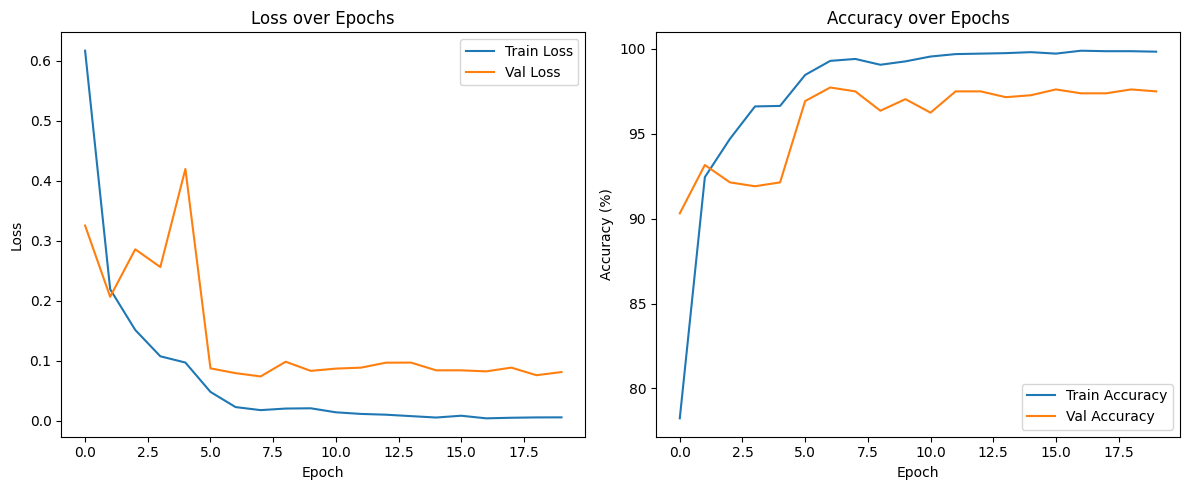

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

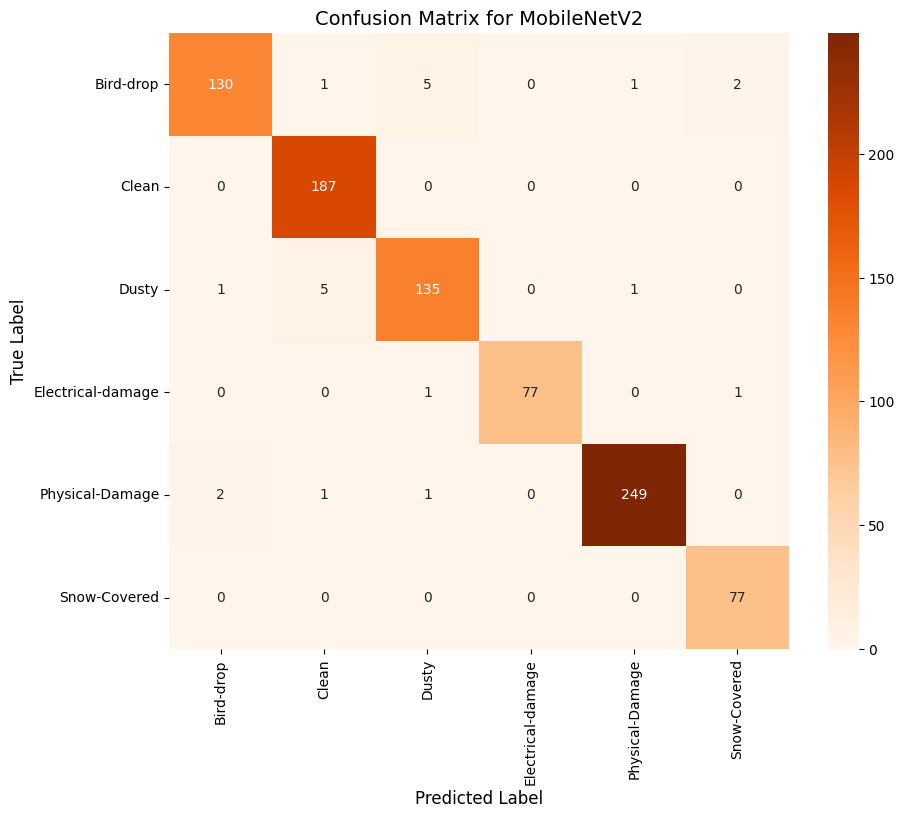

In [ ]:
def compute_confusion_matrix(model, dataloader, device, class_names):
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix for MobileNetV2", fontsize=14)
    plt.show()

compute_confusion_matrix(model, val_loader, device, class_names)


In [ ]:
def compute_classification_report(model, dataloader, device, class_names):
    y_true, y_pred = [], []


    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())


    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(" Classification Report for MobileNetV2:\n")
    print(report)


compute_classification_report(model, val_loader, device, class_names)

 Classification Report for MobileNetV2:

                   precision    recall  f1-score   support

        Bird-drop     0.9774    0.9353    0.9559       139
            Clean     0.9639    1.0000    0.9816       187
            Dusty     0.9507    0.9507    0.9507       142
Electrical-damage     1.0000    0.9747    0.9872        79
  Physical-Damage     0.9920    0.9842    0.9881       253
     Snow-Covered     0.9625    1.0000    0.9809        77

         accuracy                         0.9749       877
        macro avg     0.9744    0.9741    0.9741       877
     weighted avg     0.9752    0.9749    0.9748       877



In [ ]:
torch.save(model.state_dict(), 'model_2.pth')


In [ ]:
from google.colab import files
files.download('model_2.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Download Model and Using It In Testing

In [ ]:
uploaded = files.upload()


Saving model_2.pth to model_2 (1).pth


In [ ]:
model_path = list(uploaded.keys())[0]
print(f"Model path: {model_path}")


Model path: model_2 (1).pth


In [ ]:
def preprocess_and_predict(image_path, model, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]

    return predicted_class


In [ ]:
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]

extract_path = "/content/images"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Saving test.zip to test.zip


In [ ]:
del files
from google.colab import files
uploaded = files.upload()

zip_path = list(uploaded.keys())[0]

extract_path = "/content/images"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_paths = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))



Saving test.zip to test (2).zip


In [ ]:
def show_predictions_with_actual(image_paths, model, device, class_names, num_images=15):
    cols = 3
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, image_path in enumerate(image_paths[:num_images]):
        actual_class = os.path.splitext(os.path.basename(image_path))[0]
        predicted_class = preprocess_and_predict(image_path, model, device)

        img = Image.open(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')

        if predicted_class.lower() == actual_class.lower():
            title_color = "green"
            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}", fontsize=10, color=title_color)
        else:
            plt.title(f"Actual: {actual_class}\nPredicted: ", fontsize=10, color='black')
            plt.text(0.5, -0.25, predicted_class, fontsize=10, color='red', ha='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

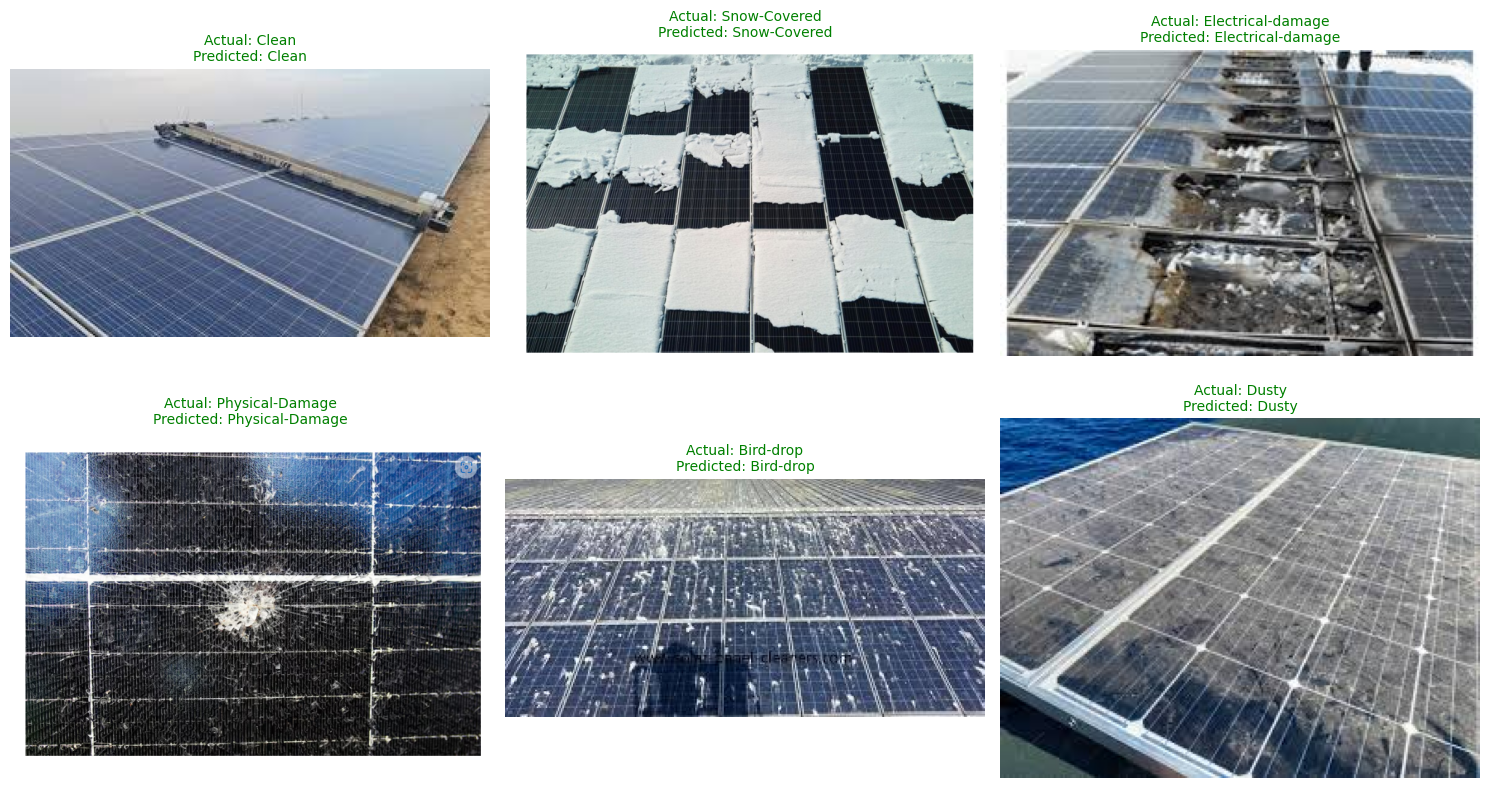

In [ ]:
show_predictions_with_actual(image_paths, model, device, class_names)


## Deployment

In [ ]:
!ngrok authtoken 2pdLLs7WF2W6K7lwhfLIsQ8bVb4_43sbVdCS765nDDzXwDndn


/bin/bash: line 1: ngrok: command not found


In [ ]:
!pip install fastapi[all] uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 19.4 MB/s eta 0:00:00


In [ ]:
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import JSONResponse
from torchvision import models, transforms
import torch
import torch.nn as nn
from PIL import Image
import io
import logging
from typing import Tuple
import os

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

app = FastAPI()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6
IMAGE_SIZE = (224, 224)

def load_model() -> nn.Module:

    try:
        model = models.mobilenet_v2(weights=None)
        model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)


        if torch.cuda.is_available():
            state_dict = torch.load(model_path)
        else:
            state_dict = torch.load(model_path, map_location='cpu')

        model.load_state_dict(state_dict)
        model.to(DEVICE)
        model.eval()
        return model
    except Exception as e:
        logger.error(f"Model loading failed: {str(e)}")
        raise RuntimeError("Could not load model") from e

model = load_model()

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_bytes: bytes) -> torch.Tensor:

    try:
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        return transform(image).unsqueeze(0).to(DEVICE)
    except Exception as e:
        logger.error(f"Image preprocessing failed: {str(e)}")
        raise ValueError("Invalid image file") from e

def predict_image(image_tensor: torch.Tensor):
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        return class_names[predicted.item()], round(confidence.item(), 4)

@app.post("/predict", response_model=dict)
async def predict(image: UploadFile = File(..., description="Image file to classify")):
    try:
        contents = await image.read()
        if not contents:
            raise HTTPException(status_code=400, detail="Empty file uploaded")

        image_tensor = preprocess_image(contents)
        class_name, confidence = predict_image(image_tensor)

        return JSONResponse(content={
            "prediction": class_name,
            "confidence": confidence,
            "status": "success"
        })

    except ValueError as e:
        logger.warning(f"Client error: {str(e)}")
        raise HTTPException(status_code=400, detail=str(e))
    except Exception as e:
        logger.error(f"Prediction failed: {str(e)}", exc_info=True)
        raise HTTPException(status_code=500, detail="Internal server error")

@app.get("/health")
async def health_check():
    return {"status": "healthy", "device": str(DEVICE)}


In [ ]:
!pip install fastapi uvicorn pyngrok nest-asyncio


In [ ]:
!ngrok authtoken 2pdLLs7WF2W6K7lwhfLIsQ8bVb4_43sbVdCS765nDDzXwDndn


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
import uvicorn
public_url = ngrok.connect(8000)
print(" Public URL:", public_url)

config = uvicorn.Config(app=app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config=config)
await server.serve()

INFO:     Started server process [795]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


 Public URL: NgrokTunnel: "https://073e-34-59-217-165.ngrok-free.app" -> "http://localhost:8000"
INFO:     54.86.50.139:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     54.86.50.139:0 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     54.86.50.139:0 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [795]
